In [73]:
import pandas as pd
import plotly.graph_objects as go
import pybamm

import pybop

In [72]:
# Load the parameters
parameter_set = pybop.ParameterSet("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 3,
        "Nominal cell capacity [A.h]": 3,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 3e-3,
        "C1 [F]": 5e2,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 2e-3,
        "C2 [F]": 3e4,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

AttributeError: 'ParameterSet' object has no attribute 'update'

In [37]:
parameter_set = pybamm.ParameterValues("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Current function [A]": 5,
        "Initial SoC": 0.5,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.0,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

In [51]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set,
    options={"number of rc elements": 2},
    solver=pybamm.CasadiSolver(mode="safe", dt_max=40),
)

In [62]:
file_loc = r"../hppc_lut/battery_G1_cycle_2_lut.csv"
df = pd.read_csv(file_loc, index_col=None, na_values=["NA"])
print(df.columns)

df = df.drop_duplicates(subset=["Time_Points"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time_Points"].to_numpy(),
        "Current function [A]": df["Current_A"].to_numpy(),
        "Voltage [V]": df["Voltage_V"].to_numpy(),
    }
)

Index(['Time_Points', 'Voltage_V', 'Current_A'], dtype='object')


In [63]:
r0_guess = 0.005
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(500, 100),
        bounds=[100, 1000],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(2000, 500),
        bounds=[1000, 10000],
    ),
)

In [66]:
# To see current vs time profile.
fig1 = go.Figure()
# Add a line trace for current vs. time
fig1.add_trace(
    go.Scatter(
        x=df["Time_Points"].to_numpy(),
        y=df["Current_A"].to_numpy(),
        mode="lines",  # 'lines', 'markers', or 'lines+markers'
        name="Current vs Time",
    )
)

# Customize layout
fig1.update_layout(
    title="Current vs Time",
    xaxis_title="Time (s)",
    yaxis_title="Current (A)",
    template="plotly",  # Use a Plotly template (optional)
)

# Show the plot
fig1.show()

In [67]:
# To see voltage vs time profile.
fig2 = go.Figure()
# Add a line trace for current vs. time
fig2.add_trace(
    go.Scatter(
        x=df["Time_Points"].to_numpy(),
        y=df["Voltage_V"].to_numpy(),
        mode="lines",  # 'lines', 'markers', or 'lines+markers'
        name="Voltage vs Time",
    )
)

# Customize layout
fig2.update_layout(
    title="Voltage vs Time",
    xaxis_title="Time (s)",
    yaxis_title="Voltage (V)",
    template="plotly",  # Use a Plotly template (optional)
)

# Show the plot
fig2.show()

In [69]:
model.build(
    initial_state={"Initial open-circuit voltage [V]": df["Voltage_V"].to_numpy()[0]}
)
problem = pybop.FittingProblem(
    model,
    parameters,
    dataset,
)

cost = pybop.SumSquaredError(problem)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\markv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybamm\parameters\parameter_values.py", line 618, in process_symbol
    try:
         
KeyError: Parameter(0x57232b486085cb03, Lower voltage cut-off [V], children=[], domains={})

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\markv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybamm\util.py", line 55, in __getitem__
KeyError: 'Lower voltage cut-off [V]'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\markv\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\markv\AppData\Local\Temp\ipykernel_26696\1582045686.py", line 1, in <module>
    model.build(
  File "c:\Users\markv\AppData

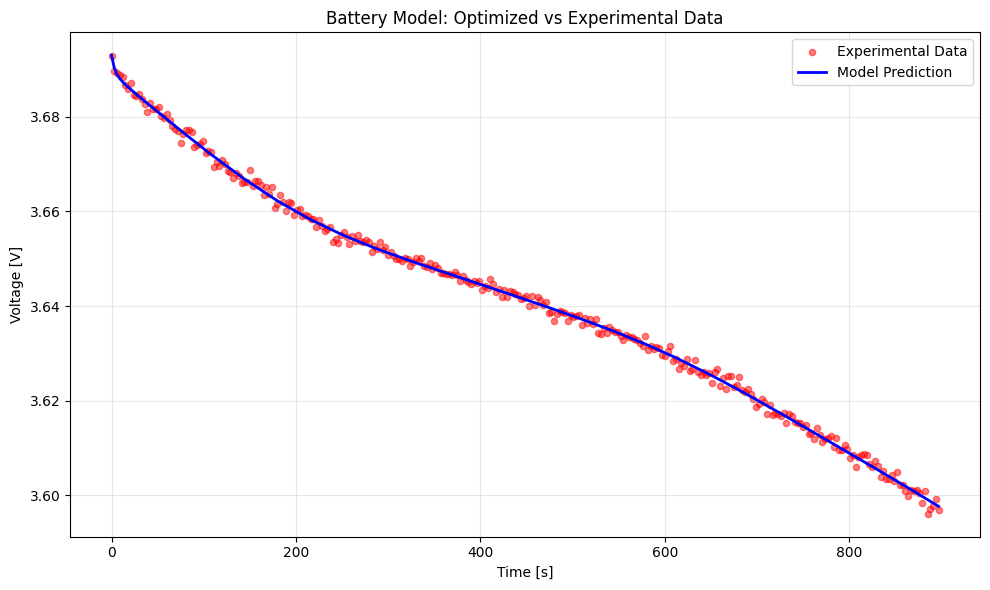

In [31]:
import matplotlib.pyplot as plt

# Get the predictions using the optimized parameters
optimized_prediction = problem.evaluate(results[0])

# Assuming `optimized_prediction` is a dictionary, extract voltage values
predicted_voltage = optimized_prediction["Voltage [V]"]

# Extract experimental data
experimental_data = problem.dataset["Voltage [V]"]
time = problem.dataset["Time [s]"]

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot experimental data
plt.scatter(time, experimental_data, color='red', label='Experimental Data', alpha=0.5, s=20)

# Plot model prediction
plt.plot(time, predicted_voltage, color='blue', label='Model Prediction', linewidth=2)

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Battery Model: Optimized vs Experimental Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()